In [ ]:
!pip install mutagen
!pip install librosa
!pip install pytables
!pip install tables
!pip install fastparquet
!pip install pyarrow
!pip install cupy-cuda12x


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not find a version that satisfies the requirement pytables (from versions: none)
ERROR: No matching distribution found for pytables

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for pyarrow from https://files.pythonhosted.org/packages/10/15/6b30e77872012bbfe8265d42a01d5b3c17ef0ac0f2fae531ad91b6a6c02e/pyarrow-21.0.0-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 26.2/26.2 MB 3.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import mutagen
import os
from pathlib import Path
import librosa
import pandas as pd
import warnings
import re
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import cupyx.scipy.fft as cufft
import scipy.fft

In [5]:
current_dir = Path(os.getcwd())
linkin_park = current_dir / 'previews' / 'BURN IT DOWN - Linkin Park - LIVING THINGS.mp3'

In [6]:
linkin_park_file = mutagen.File(linkin_park)
linkin_park_file.info.pprint()

'MPEG 1 layer 3, 128000 bps (CBR?), 44100 Hz, 2 chn, 29.99 seconds'

In [ ]:
MAKE_AMPS = False

if MAKE_AMPS:
    warnings.filterwarnings('ignore', category=UserWarning)
    output_file_path = 'output_dataset_with_amp_uri.feather'

    if os.path.exists(output_file_path):
        print(f"file exists {output_file_path}. deleting it.")
        os.remove(output_file_path)

    clear_dataset = pd.read_csv('cleared.csv')

    clear_dataset = clear_dataset.astype({
        "energy": "float64",
        "tempo": "float64",
        "danceability": "float64",
        "playlist_genre": "string",
        "loudness": "float64",
        "liveness": "float64",
        "valence": "float64",
        "track_artist": "string",
        "time_signature": "int64",
        "speechiness": "float64",
        "track_popularity": "int64",
        "track_album_name": "string",
        "track_name": "string",
        "instrumentalness": "float64",
        "mode": "int64",
        "key": "int64",
        "acousticness": "float64",
        "playlist_subgenre": "string",
        "type": "string",
        "playlist_id": "string",
    })

    clear_dataset["track_album_release_date"] = pd.to_datetime(clear_dataset["track_album_release_date"], errors="coerce").dt.strftime("%Y-%m")


In [ ]:
if MAKE_AMPS:
    os.makedirs("amps", exist_ok=True)
    for _, row in clear_dataset.iterrows():
        song_name = row["track_name"]
        artist = row["track_artist"]
        album = row["track_album_name"]
        
        title_mp3 = f"{song_name} - {artist} - {album}"
        title_mp3 = re.sub(r'[\\/*?:"<>|]', "_", f"{song_name} - {artist} - {album}")

        uri_path = f"amps/{_}.npy"
        try:
            file_path = os.path.join("previews", f"{title_mp3}.mp3")
            y, sr = librosa.load(file_path, sr=None)
        except:
            song_name = re.sub(r'[\\/*?:"<>|]', "_", f"{song_name}")
            pattern = re.compile(rf"^{re.escape(song_name)}.*\.mp3$", re.IGNORECASE)
            matches = [f for f in os.listdir('previews') if pattern.match(f)]
            file_path = os.path.join('previews', matches[0])
            y, sr = librosa.load(file_path, sr=None)


        if os.path.exists(uri_path):
            print(f"file exists {uri_path}. deleting it.")
            os.remove(uri_path)
        np.save(uri_path, y)
        clear_dataset.loc[_, "amp_path"] = uri_path
        clear_dataset.loc[_, "sampling_rate"] = sr

    output_feather_path = "output_dataset_with_amp_uri.feather"
    clear_dataset.to_feather(output_feather_path)



c:\Users\grzto\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
cp.cuda.runtime.getDeviceCount()
cp.show_config()

OS                           : Windows-10-10.0.26100-SP0
Python Version               : 3.9.4
CuPy Version                 : 13.6.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 1.23.5
SciPy Version                : 1.10.1
Cython Build Version         : 3.0.12
Cython Runtime Version       : None
CUDA Root                    : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6
nvcc PATH                    : C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6\bin\nvcc.EXE
CUDA Build Version           : 12090
CUDA Driver Version          : 12090
CUDA Runtime Version         : 12090 (linked to CuPy) / RuntimeError("CuPy failed to load cudart64_12.dll: FileNotFoundError: Could not find module 'cudart64_12.dll' (or one of its dependencies). Try using the full path with constructor syntax.") (locally installed)
CUDA Extra Include Dirs      : (NVRTC unavailable)
cuBLAS Version               : (available)
cuFFT Version                : None
cuRAND Version 

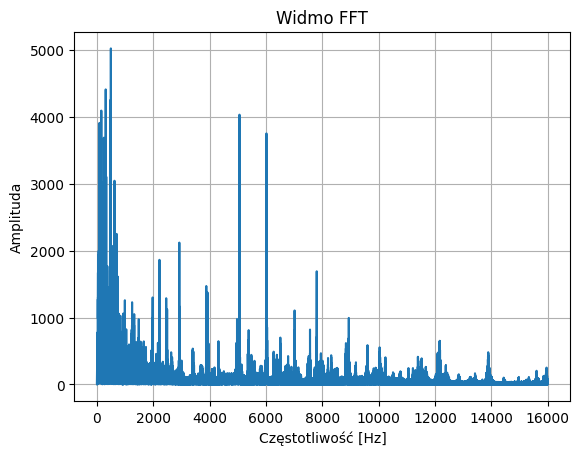

In [ ]:
feather = pd.read_feather('output_dataset_with_amp_uri.feather')
track_index = feather.index[feather["track_name"] == "BURN IT DOWN"][0]
track_name = feather.loc[track_index, 'track_name']
track_amp_uri = feather.loc[track_index, 'amp_path']
track_sr = int(feather.loc[track_index, 'sampling_rate'])

fs = track_sr
x = np.load(track_amp_uri)
t = fs * len(x)

# FFT
X = np.fft.fft(x)
freqs = np.fft.fftfreq(len(x), 1/fs)

idx = (freqs >= 0) & (freqs <= 16000)
plt.plot(freqs[idx], np.abs(X[idx]))

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.title("FFT")
plt.grid(True)
plt.show()


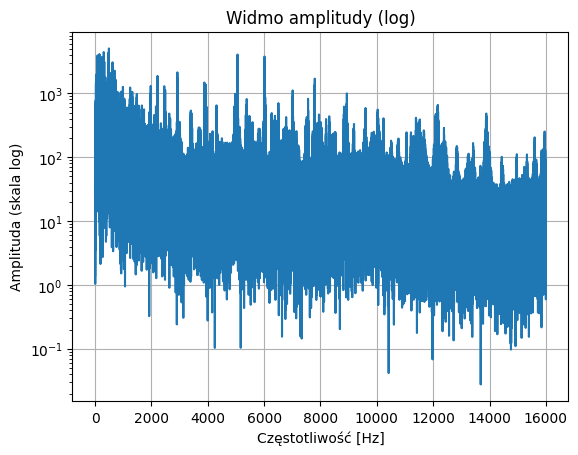

In [ ]:
plt.semilogy(freqs[idx], np.abs(X[idx]))

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude (log)")
plt.title("FFT (log)")
plt.grid(True)
plt.show()


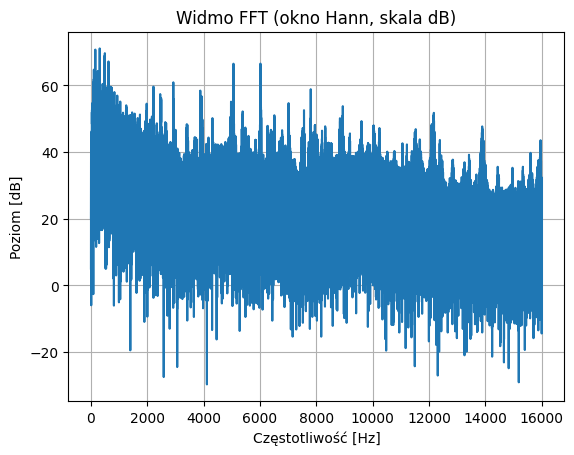

In [ ]:
window = np.hanning(len(x))
X = np.fft.fft(x * window)

X_db = 20 * np.log10(np.abs(X) + 1e-12)

plt.plot(freqs[idx], X_db[idx])
plt.xlabel("Frequency [Hz]")
plt.ylabel("level [dB]")
plt.title("FFT (Hann window, dB sale)")
plt.grid(True)
plt.show()

c:\Users\grzto\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


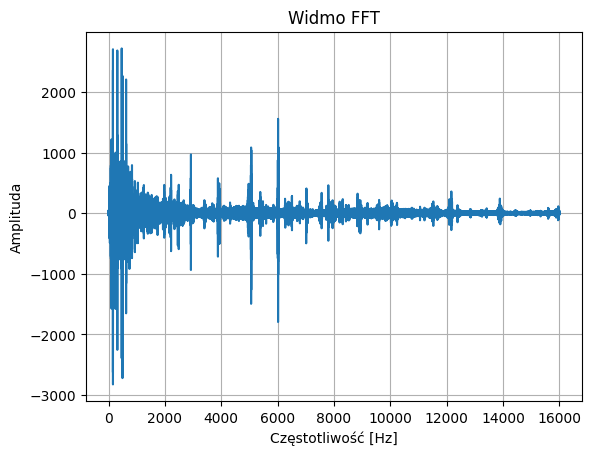

In [ ]:
window = np.hanning(len(x))
X = np.fft.fft(x * window)

plt.plot(freqs[idx], X[idx])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.title("FFT")
plt.grid(True)
plt.show()

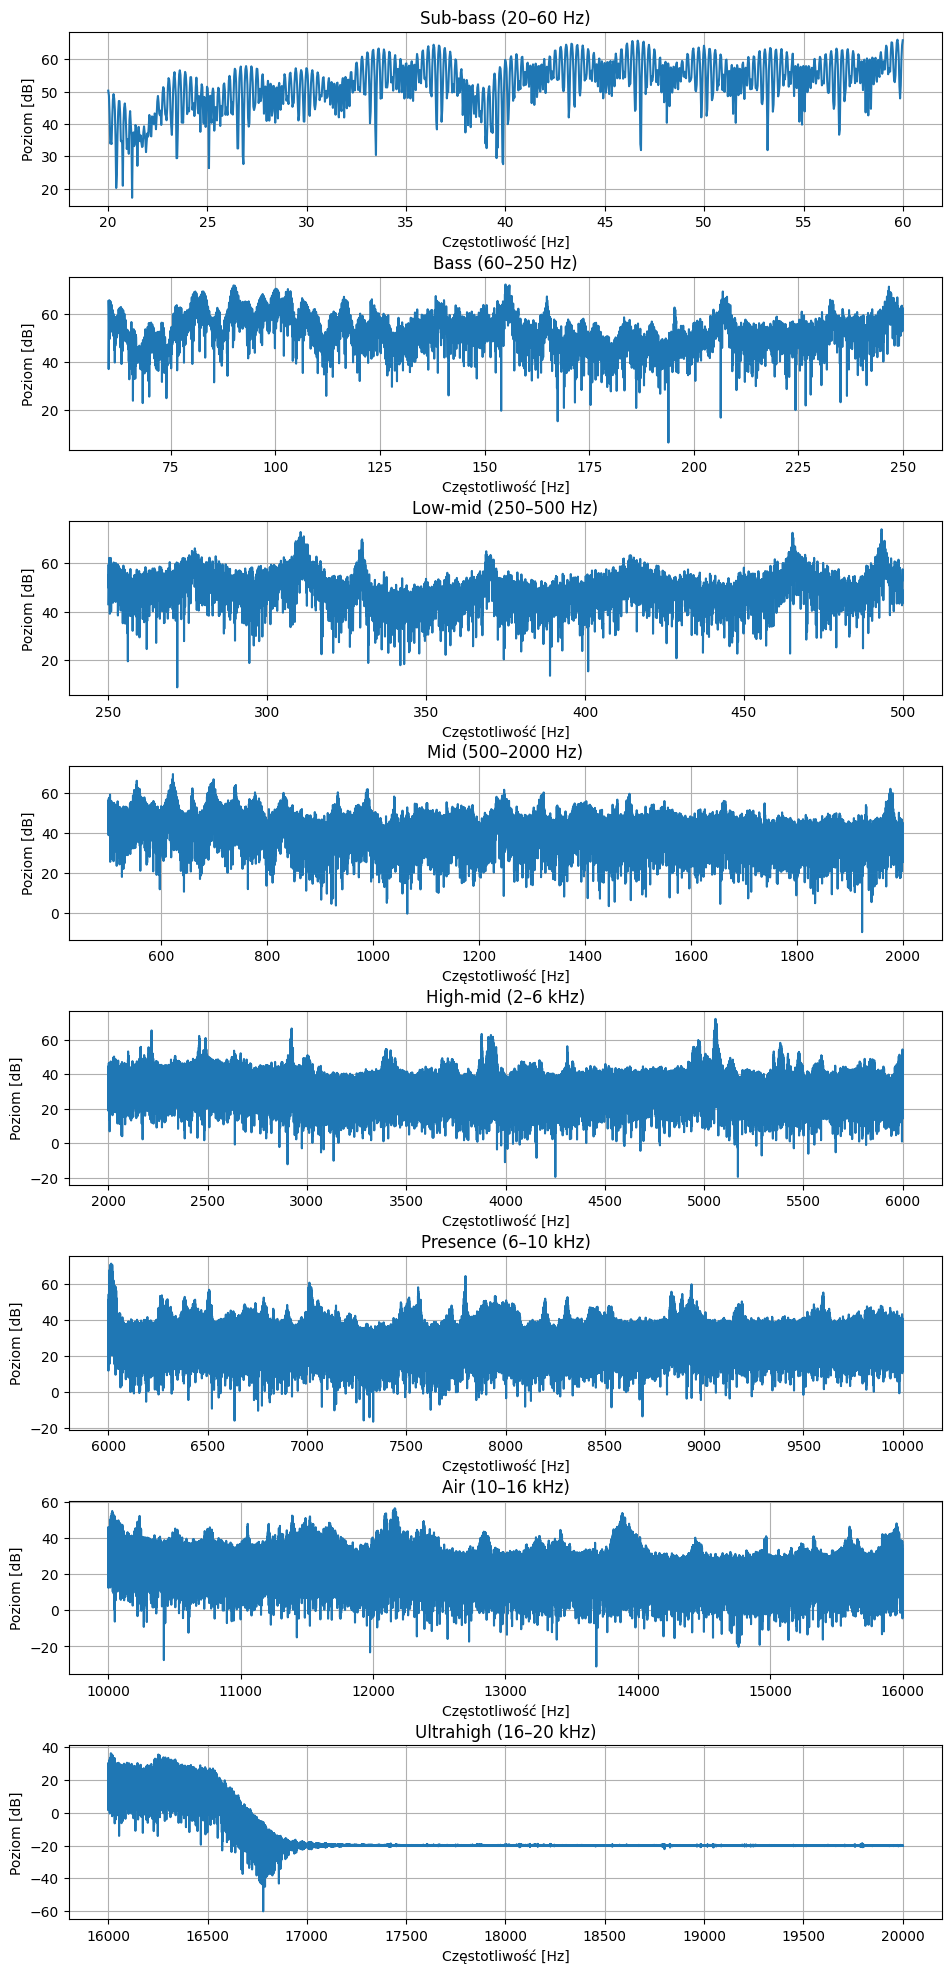

In [ ]:
fs = track_sr
x = np.load(track_amp_uri)

X = np.fft.fft(x)
freqs = np.fft.fftfreq(len(x), 1/fs)

idx = freqs >= 0
freqs = freqs[idx]
X = X[idx]

X_db = 20 * np.log10(np.abs(X) + 1e-12)

bands = {
    "Sub‑bass (20–60 Hz)":        (20, 60),
    "Bass (60–250 Hz)":           (60, 250),
    "Low‑mid (250–500 Hz)":       (250, 500),
    "Mid (500–2000 Hz)":          (500, 2000),
    "High‑mid (2–6 kHz)":         (2000, 6000),
    "Presence (6–10 kHz)":        (6000, 10000),
    "Air (10–16 kHz)":            (10000, 16000),
    "Ultrahigh (16–20 kHz)":      (16000, 20000),
}

fig, axes = plt.subplots(len(bands), 1, figsize=(10, 20))
fig.tight_layout(pad=3)

for ax, (name, (low, high)) in zip(axes, bands.items()):
    mask = (freqs >= low) & (freqs <= high)
    ax.plot(freqs[mask], X_db[mask])
    ax.set_title(name)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Level [dB]")
    ax.grid(True)

plt.show()


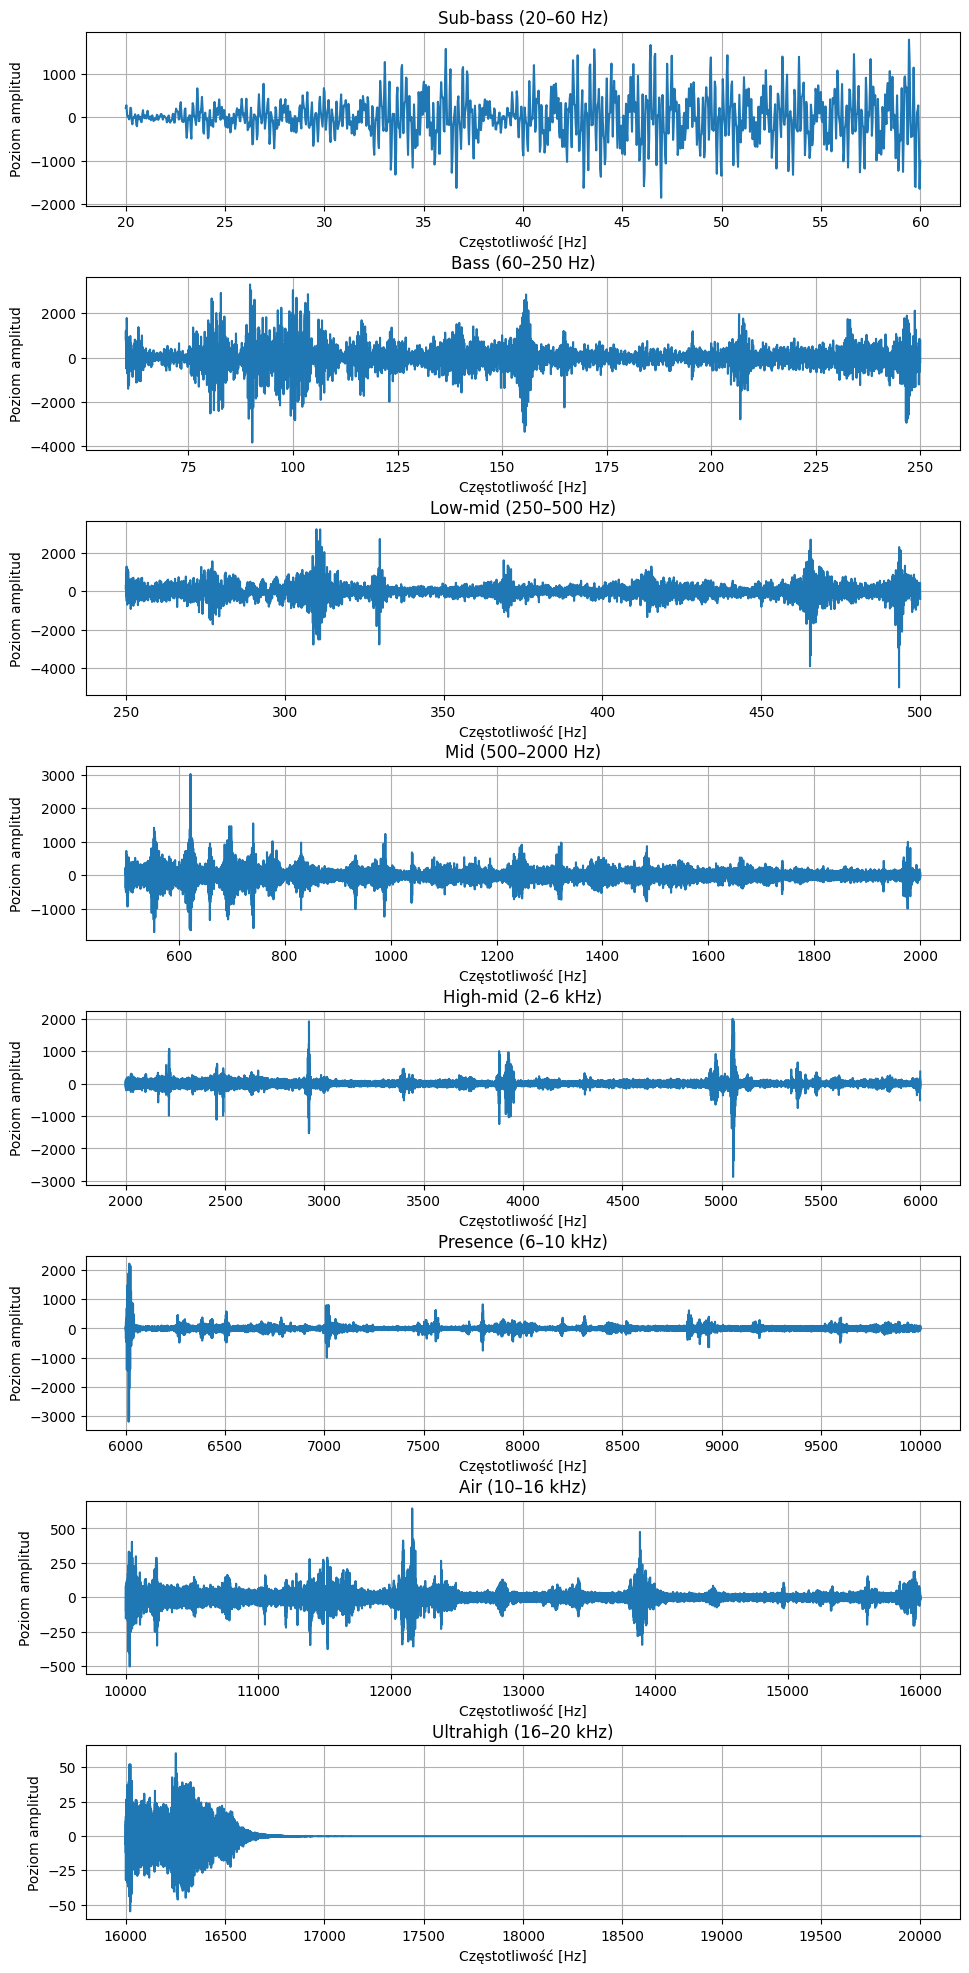

In [ ]:
fs = track_sr
x = np.load(track_amp_uri)

X = np.fft.fft(x)
freqs = np.fft.fftfreq(len(x), 1/fs)

idx = freqs >= 0
freqs = freqs[idx]
X = X[idx]

bands = {
    "Sub‑bass (20–60 Hz)":        (20, 60),
    "Bass (60–250 Hz)":           (60, 250),
    "Low‑mid (250–500 Hz)":       (250, 500),
    "Mid (500–2000 Hz)":          (500, 2000),
    "High‑mid (2–6 kHz)":         (2000, 6000),
    "Presence (6–10 kHz)":        (6000, 10000),
    "Air (10–16 kHz)":            (10000, 16000),
    "Ultrahigh (16–20 kHz)":      (16000, 20000),
}

fig, axes = plt.subplots(len(bands), 1, figsize=(10, 20))
fig.tight_layout(pad=3)

for ax, (name, (low, high)) in zip(axes, bands.items()):
    mask = (freqs >= low) & (freqs <= high)
    ax.plot(freqs[mask], X[mask])
    ax.set_title(name)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

plt.show()
